In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from fydyc_dataset import FydycDataset
import os



dataset = FydycDataset(csv_file='fydyc/fydyc_real.csv')
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=1000, shuffle=True, num_workers=2)

In [2]:
import torch.nn as nn

class MLP(nn.Module):
   
    def __init__(self, hidden_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(1, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x


100%|██████████████████████████████████████████████████████████████| 10/10 [07:39<00:00, 45.90s/it]


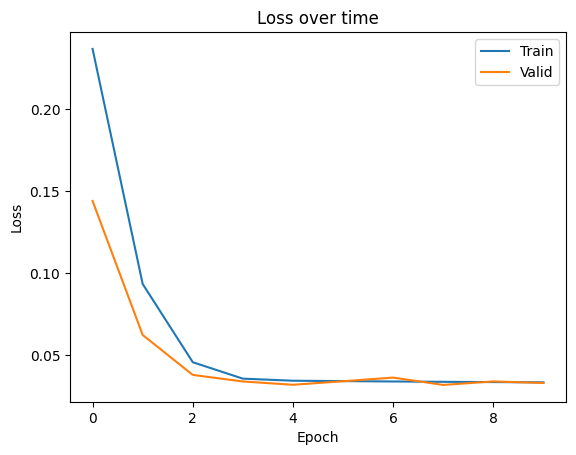

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

model = MLP(hidden_size=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses = []  # 保存每个周期的训练损失
valid_losses = []  # 保存每个周期的验证损失
for epoch in tqdm(range(10)):
    # 训练阶段
    epoch_train_losses = []  # 保存每个批次的训练损失
    for data in train_dataloader:
        inputs, labels = data
        inputs = inputs.view(-1, 1)
        labels = labels.view(-1, 1)
        output = model(inputs)

        loss = criterion(output, labels)
        epoch_train_losses.append(loss.item())  # 保存每个批次的训练损失

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)  # 计算每个周期的平均训练损失
    train_losses.append(epoch_train_loss)  # 保存每个周期的训练损失

    # 验证阶段
    epoch_valid_losses = []  # 保存每个批次的验证损失
    with torch.no_grad():  # 不需要计算梯度
        for data in valid_dataloader:
            inputs, labels = data
            inputs = inputs.view(-1, 1)
            labels = labels.view(-1, 1)
            output = model(inputs)

            loss = criterion(output, labels)
            epoch_valid_losses.append(loss.item())  # 保存每个批次的验证损失

    epoch_valid_loss = sum(epoch_valid_losses) / len(epoch_valid_losses)  # 计算每个周期的平均验证损失
    valid_losses.append(epoch_valid_loss)  # 保存每个周期的验证损失

    if epoch+1 % 10 == 0:  # 每10个周期打印一次损失
        print(f"Train loss at epoch {epoch}: {epoch_train_loss}")
        print(f"Valid loss at epoch {epoch}: {epoch_valid_loss}")

# 绘制训练损失和验证损失
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()
plt.show()


In [4]:
torch.save(model.state_dict(), 'fydyc/model.pth')
modeltest = MLP(hidden_size=10)
modeltest.load_state_dict(torch.load('fydyc/model.pth'))

<All keys matched successfully>

In [5]:
modeltest(torch.tensor([0.6]))

tensor([0.4187], grad_fn=<ViewBackward0>)

In [9]:
import numpy as np

real_value = np.array([[19900]])  # 假设你的真实值是10
normalized_value = dataset.scaler_features.transform(real_value)
input_tensor = torch.from_numpy(normalized_value).float()
input_tensor = input_tensor.view(1, -1)  # 确保其形状与模型输入的形状相匹配
model.eval()  # 将模型设置为评估模式
with torch.no_grad():  # 不需要计算梯度
    output_tensor = model(input_tensor)
output_value = output_tensor.numpy()  # 将输出张量转换为 numpy 数组
predicted_value = dataset.scaler_labels.inverse_transform(output_value)
print(predicted_value)  # 打印预测值


[[14452.1]]
